## **Anime Recommendation Dataset**
---

## Objectives and Rationale

วัตถุประสงค์ของ notebook นี้คือต้องการที่จะสร้างระบบแนะนำ anime ให้กับ user โดยการตั้งสมมติฐานว่า user ที่มีพฤติกรรมความชอบ anime ที่คล้ายๆกัน จะมีความชอบใน anime เรื่องอื่นๆเหมือนกัน โดยเราจะใช้ข้อมูลความชอบของ user 73,516 users ใน anime 12,294 เรื่อง และแต่ละ user จะสามารถให้ rating ของ anime แต่ละเรื่องตามความชอบได้

Download dataset from: https://www.kaggle.com/CooperUnion/anime-recommendations-database



[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1BncJGmCwiezahoeJYs2fHmf1tb9G84YD?authuser=1)

In [ ]:
!pip install fastai==2.2.7

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from fastai.collab import *
from fastai.tabular.all import *

%matplotlib inline

In [3]:
!wget https://github.com/opalchonlapat/anime-recommend/raw/master/anime.zip
!unzip anime.zip -d anime-recommedations-datbase

--2021-03-16 03:26:12--  https://github.com/opalchonlapat/anime-recommend/raw/master/anime.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/opalchonlapat/anime-recommend/master/anime.zip [following]
--2021-03-16 03:26:12--  https://raw.githubusercontent.com/opalchonlapat/anime-recommend/master/anime.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26259955 (25M) [application/zip]
Saving to: ‘anime.zip’

anime.zip           100%[===================>]  25.04M  53.5MB/s    in 0.5s    

2021-03-16 03:26:13 (53.5 MB/s) - ‘anime.zip’ saved [26259955/26259955]

Archive:  anime.zip
  inflating: an

In [4]:
rating_df = pd.read_csv("anime-recommedations-datbase/rating.csv")
anime_df = pd.read_csv("anime-recommedations-datbase/anime.csv")

## Data exploration

In [5]:
print(f"Rating shape: {rating_df.shape}")
rating_df.info()

Rating shape: (7813737, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


In [6]:
rating_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [7]:
print(f"Anime shape: {anime_df.shape}")
anime_df.info()

Anime shape: (12294, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [8]:
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Military, Shounen",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",TV,51,9.16,151266


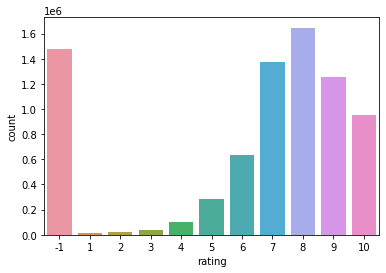

In [9]:
sns.countplot(x='rating', data=rating_df)

rating จะอยู่ระหว่าง 1-10 ถ้า rating = -1 หมายความว่า user ได้ดู anime เรื่องนั้น แต่ไม่ได้ให้ rating เพราะฉะนั้นเราจะทำการ filter anime ที่ user ไม่ให้ rating ออกไป

In [10]:
rating_df = rating_df[rating_df.rating >= 0].reset_index(drop=True)

In [11]:
rating_df.head()

,user_id,anime_id,rating
0,1,8074,10
1,1,11617,10
2,1,11757,10
3,1,15451,10
4,2,11771,10


In [12]:
print(f"Number of users rated: {rating_df['user_id'].nunique()}")

Number of users rated: 69600


User แต่ละคน ให้ rating ของ anime กี่เรื่อง

In [13]:
user_grouped = rating_df.groupby(['user_id'])['anime_id'].count().reset_index(name='num_rate_anime')
user_grouped

,user_id,num_rate_anime
0,1,4
1,2,1
2,3,92
3,5,459
4,7,343
...,...,...
69595,73512,12
69596,73513,33
69597,73514,1
69598,73515,179


(0.0, 1000.0)

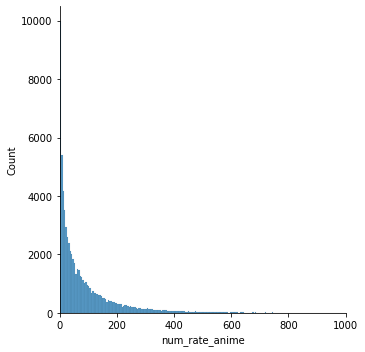

In [14]:
sns.displot(x='num_rate_anime', data=user_grouped)
plt.xlim(0, 1000)

User แต่ละคนให้ rating เฉลี่ยอยู่ที่คะแนน

In [15]:
def find_mean_drop_outlier(ser):
    ser = ser.dropna()
    q1, q3 = ser.quantile(q=[0.25, 0.75]).values
    iqr = q3 - q1
    upper_out = q3 + (1.5 * iqr)
    lower_out = q1 - (1.5 * iqr)
    return ser[(ser >= lower_out) & (ser <= upper_out)].mean()

In [16]:
mean_rate_df = rating_df.groupby(['user_id'])['rating'].apply(find_mean_drop_outlier)

In [17]:
mean_rate_df = mean_rate_df.reset_index()

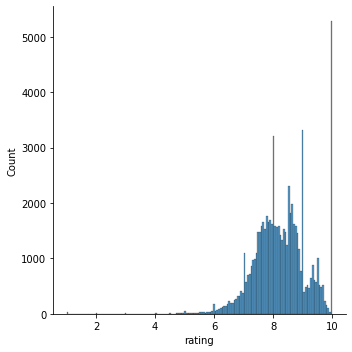

In [18]:
sns.displot(x='rating', data=mean_rate_df)

Anime แต่ละเรื่อง มีค่าเฉลี่ย rating อยู่ที่กี่คะแนน

In [19]:
anime_mean_rate_df = rating_df.groupby(['anime_id'])['rating'].apply(find_mean_drop_outlier)

In [20]:
anime_mean_rate_df = anime_mean_rate_df.reset_index()

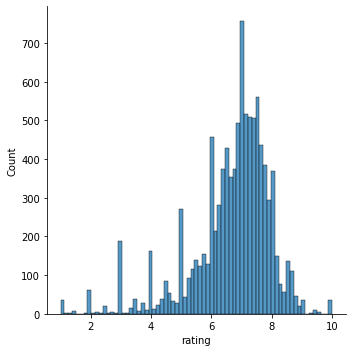

In [21]:
sns.displot(x='rating', data=anime_mean_rate_df)

explore ดูว่า anime แต่ละเรื่อง มีจำนวน user ที่ให้ rating กี่คน

In [22]:
anime_grouped_df = rating_df.groupby(['anime_id'])['user_id'].count().reset_index(name='rating_cnt')
anime_grouped_df = pd.merge(anime_grouped_df, anime_df[['anime_id', 'name']], on=['anime_id'])
anime_grouped_df = anime_grouped_df.sort_values(['rating_cnt'], ascending=False)

Text(0.5, 1.0, 'Top 10 anime based on number of users rated')

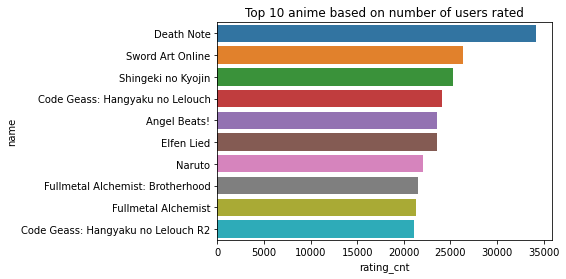

In [23]:
sns.barplot(y='name', x='rating_cnt', data=anime_grouped_df.head(10))
plt.title("Top 10 anime based on number of users rated")

Text(0.5, 1.0, 'Top 10 anime based on number of members')

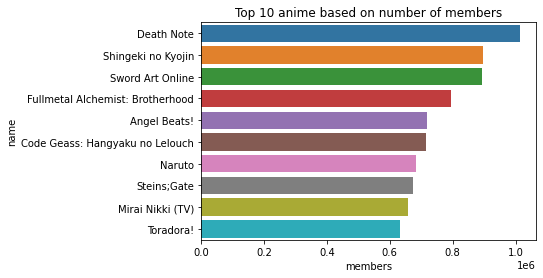

In [24]:
anime_df = anime_df.sort_values(['members'], ascending=False)
sns.barplot(y='name', x='members', data=anime_df.head(10))
plt.title("Top 10 anime based on number of members")

## Modeling

In [25]:
rating_df

,user_id,anime_id,rating
0,1,8074,10
1,1,11617,10
2,1,11757,10
3,1,15451,10
4,2,11771,10
...,...,...,...
6337236,73515,16512,7
6337237,73515,17187,9
6337238,73515,22145,10
6337239,73516,790,9


In [26]:
rating_grouped_df = rating_df.groupby(['user_id'])
valid_df = rating_grouped_df.apply(lambda x: x.sample(frac=.1, random_state=1))

In [30]:
valid_df.index = valid_df.index.droplevel()

In [35]:
train_df = rating_df[~rating_df.index.isin(valid_df.index)]

In [36]:
print(f"""
Train shape: {train_df.shape}
Train unique users: {train_df['user_id'].nunique()}
Valid shape: {valid_df.shape}
Valid unique users: {valid_df['user_id'].nunique()}
""")


Train shape: (5704999, 3)
Train unique users: 69600
Valid shape: (632242, 3)
Valid unique users: 59614



In [37]:
n_users, n_animes, n_ratings = list(train_df.nunique())

In [39]:
# prepare dataloader
dls = CollabDataLoaders.from_df(
    train_df,
    valid_pct=0.2,
    user_name="user_id",
    item_name="anime_id",
    rating_name="rating",
    bs=64
)

In [40]:
dls.show_batch()

,user_id,anime_id,rating
0,50143,552,8
1,17095,14941,10
2,5892,2268,8
3,7284,1639,5
4,2115,10719,8
5,62830,72,9
6,25523,239,9
7,50686,1015,7
8,10204,13535,7
9,17351,2001,10


## **Train data using Collab Learner**

In [41]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 10.5))

In [42]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,2.429470,2.369071,09:35
1,2.379527,2.381012,09:34
2,2.251287,2.211402,09:29
3,1.967032,1.973353,09:27
4,1.895646,1.840371,09:31


In [43]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [44]:
learn.save("models")

Path('/content/drive/MyDrive/models.pth')